<a href="https://colab.research.google.com/github/Gratisfo/project_ml/blob/main/depressive_posts_in_Russian_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Dataset of depressive posts in Russian language collected from social media** [(paper)](https://www.sciencedirect.com/science/article/pii/S2352340920300895)

Скачать датасет в формате .tsv можно [здесь](https://yadi.sk/d/G5rq-R3AK8SOuw).


Задачи:
1. Использовать ```pandas``` и ряд инструментов для автоматической обработки текстов на русском языке, чтобы ответить на вопросы.
2. Написать функции для извлечения текстовых признаков.



In [ ]:
import pandas as pd

df = pd.read_csv("depression_data.tsv", sep="\t")
df.head()

,text,label,age
0,"Когда-то я был добрым романтиком, который стре...",1,32.0
1,Здраствуйте! Я каждый день просыпаюсь с мыслью...,1,28.0
2,У меня проблемы с девушкой. Каждую ссору я не ...,1,16.0
3,"Вся моя жизнь это один сплошной ад, в котором ...",1,32.0
4,Я хочу уснуть и не проснуться.каждый день одно...,1,14.0


### Часть 1: Простая статистика 

1. Среднее значение возраста в диапазоне от 14 до 50 лет включительно.

In [ ]:
stat1 = df[(df['age'] <=50) & (df['age'] >= 14)]
stat1.mean()

label     1.000000
age      22.704172
dtype: float64

2. Доля 16-летних авторов диапазоне от 16 до 26 лет включительно

In [ ]:
stat2 = df[(df['age'] <=26) & (df['age'] >= 16)]
stat2.age.value_counts(normalize=True)

16.0    0.125941
17.0    0.125112
18.0    0.114750
20.0    0.106598
19.0    0.096857
21.0    0.087945
22.0    0.079724
23.0    0.077375
25.0    0.069845
24.0    0.063351
26.0    0.052504
Name: age, dtype: float64

3. Количество текстов, авторам которых 28 или 30 лет

In [ ]:
stat3 = df.query("age in [28, 30]")
stat3.age.value_counts()

28.0    608
30.0    577
Name: age, dtype: int64

4. Вся татистика по колонке ```age``` в диапазоне от 18 до 30 лет включительно.

In [ ]:
stat4 = df[(df['age'] <=30) & (df['age'] >= 18)]
stat4.describe()

,label,age
count,13205.0,13205.000000
mean,1.0,22.676638
std,0.0,3.550254
min,1.0,18.000000
25%,1.0,20.000000
50%,1.0,22.000000
75%,1.0,25.000000
max,1.0,30.000000


5. Количество в датасете положительных / отрицательных примеров

In [ ]:
df['label'].value_counts()


0    32021
1    32018
Name: label, dtype: int64

In [ ]:
df[(df['label'] ==1)].text

0        Когда-то я был добрым романтиком, который стре...
1        Здраствуйте! Я каждый день просыпаюсь с мыслью...
2        У меня проблемы с девушкой. Каждую ссору я не ...
3        Вся моя жизнь это один сплошной ад, в котором ...
4        Я хочу уснуть и не проснуться.каждый день одно...
                               ...                        
32013    # Депрессия - это гораздо больше, чем просто г...
32014    Вы можете избежать обидчика, но насилие никогд...
32015    У меня #CerebralPalsy & #depression. CP не улу...
32016    Ты не невидимка, ты не бремя, ты потрясающий! ...
32017    Вчера вечером ходил на Волшебное Лекарство в @...
Name: text, Length: 32018, dtype: object

### Часть 2: Предобработка 

1. Количество предложений в каждом тексте. 

In [ ]:
from razdel import sentenize, tokenize

def get_num_sentences(text):
    segmented_sentences = sentenize(text)
    num_sentences = len(list(segmented_sentences))
    return num_sentences


In [ ]:
for index, text in enumerate(df['text']):
    df.loc[index, 'len_sent'] = get_num_sentences(text)

2. Токенизации текста. Удаление стоп-слова.

In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from string import ascii_letters


def tokenize_text(text):
    # токенизируем
    tokens = [_.text for _ in list(tokenize(text))]
    
    # приводим к нижнему регистру
    tokens = [w.lower() for w in tokens]
    
    # убираем пунктуацию
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # убираем числа и оставлем только кирилицу
    words = [word for word in stripped if word.isalpha()
             and not all(map(lambda c: c in ascii_letters, word))]
    
    # удаляем стоп-слова
    stop_words = set(stopwords.words('russian'))
    words = [w for w in words if not w in stop_words]
    
    text = ' '.join(words)
    return words

3. Количество токенов в тексте (без стоп-слов). Среднее этих значений как по всей выборке, так и внутри каждого класса. 

In [ ]:
def get_num_tokens(text):
    num_tokens = len(tokenize_text(text))
    return num_tokens

In [ ]:
for index, text in enumerate(df['text']):
    df.loc[index, 'len_tokens'] = get_num_tokens(text)

In [ ]:
print('среднее значений по всей выборке', df.len_tokens.mean())
print('среднее значений внутри класса label=0', df[df['label']==0].len_tokens.mean())
print('среднее значений внутри класса label=1', df[df['label']==1].len_tokens.mean())


среднее значений по всей выборке 97.92175080810131
среднее значений внутри класса label=0 127.18556572249462
среднее значений внутри класса label=1 68.65519395340121


4. Функция, которая переводит текст в последовательность лемм.

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def get_lemm(text):
    lemm = [morph.parse(w)[0].normal_form for w in tokenize_text(text)]
    return lemm

5. Функция, которая переводит текст в последовательность частеречных тегов.

In [ ]:
def get_speech_part(text):
    text = tokenize_text(text)
    tags = [morph.parse(word)[0].tag.POS  for word in text]
    return tags

### Часть 3: Визуализация 

1. Распределение количество предложений / текст.

<AxesSubplot:>

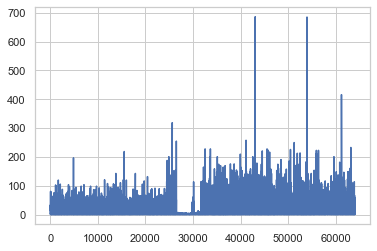

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df['len_sent'].plot()

2. Распределение количество-предложений / текст внутри каждого класса.

Text(0.5, 1.0, 'label 1')

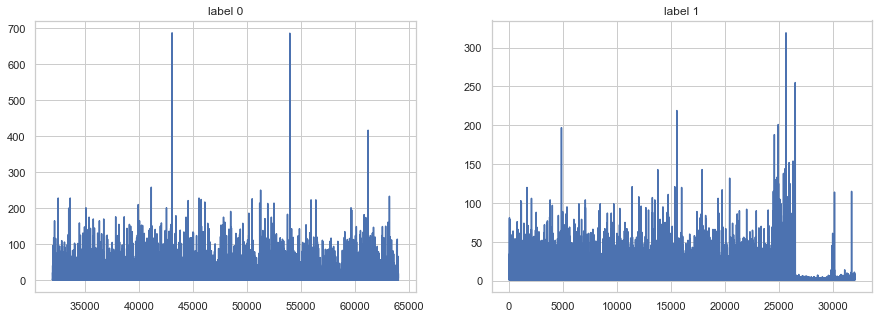

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
df[df['label']==0].len_sent.plot(ax = axes[0])
df[df['label']==1].len_sent.plot(ax = axes[1])

axes[0].set_title('sent len in label 0')
axes[1].set_title('sent len in label 1')

3. Матрица корреляции количеств в предложений в тексте с возрастом автора в подвыборке от 16 до 32 лет включительно

In [ ]:
agelen_df = df[['age','len_sent']]
agelen_df.head()

,age,len_sent
0,32.0,15.0
1,28.0,6.0
2,16.0,10.0
3,32.0,5.0
4,14.0,18.0


In [ ]:
agelen_df.corr()

,age,len_sent
age,1.000000,-0.004896
len_sent,-0.004896,1.000000


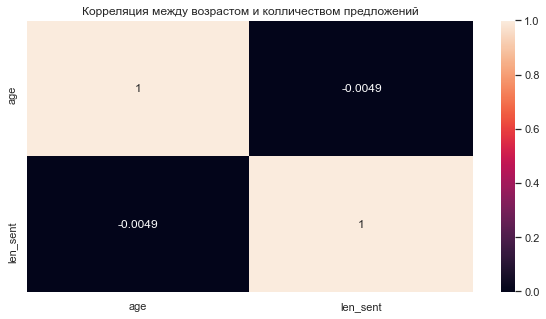

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    data=agelen_df.corr(), 
    annot=True,
    ax=ax
)

plt.title("Корреляция между возрастом и колличеством предложений")
plt.show()

Верно, что количество предложений в тексте коррелирует с возрастом автора в подвыборке от 16 до 32 лет включительно.
Корреляция – отрицательная 

### Часть 4: Извлечение текстовых признаков (4 балла)

1. Функци для получения посимвольных н-грамм (без использования библиотек).

In [ ]:
def char_ngrams(text, n):
    grams = []
    
    for i in range(len(text)):
        part = [text[i:i+n]]
        for gram in part:
            if len(gram) == n:
                grams.append(gram)
    return grams

In [ ]:
# пример работы функции

text = "уставшая мама мыла грязную раму"

char_ngrams(text, n=3)[:10]

['уст', 'ста', 'тав', 'авш', 'вша', 'шая', 'ая ', 'я м', ' ма', 'мам']

2. Фунция для получения пословных н-грамм (без использования библиотек).

In [ ]:
def word_ngrams(text, n):
    grams = []
    text = text.split()
    for i in range(len(text)):
        part = [text[i:i+n]]
        for gram in part:
            if len(gram) == n:
                grams.append(gram)
    return grams

In [ ]:
word_ngrams(text, n=4)

[['уставшая', 'мама', 'мыла', 'грязную'], ['мама', 'мыла', 'грязную', 'раму']]

3. Функция для получения н-грамм лемм (без использования библиотек).

In [ ]:
def lemma_ngrams(text, n):
    grams = []
    text = get_lemm(text)
    for i in range(len(text)):
        part = [text[i:i+n]]
        for gram in part:
            if len(gram) == n:
                grams.append(gram)
    return grams

In [ ]:
lemma_ngrams(text, n=4)

[['устать', 'мама', 'мыло', 'грязный'], ['мама', 'мыло', 'грязный', 'рам']]

4. Функция для получения н-грамм частеречных тегов (без использования библиотек).

In [ ]:
def pos_ngrams(text, n):
    grams = []
    text = get_speech_part(text)
    for i in range(len(text)):
        part = [text[i:i+n]]
        for gram in part:
            if len(gram) == n:
                grams.append(gram)
    return grams

In [ ]:
# пример работы функции

pos_ngrams(text, n=3)

[['PRTF', 'NOUN', 'NOUN'], ['NOUN', 'NOUN', 'ADJF'], ['NOUN', 'ADJF', 'NOUN']]

In [ ]:
pos_ngrams(text, n=4)

[['PRTF', 'NOUN', 'NOUN', 'ADJF'], ['NOUN', 'NOUN', 'ADJF', 'NOUN']]

5. Функция для получения частотного словаря частеречных тегов по коллекции документов.

In [ ]:
def build_pos_dict(corpus):
    text = ' '.join(corpus)
    pos = get_speech_part(text)
    pos_dict = {}
    for i in pos:
        if i in pos_dict:
            pos_dict[i] += 1
        else:
            pos_dict[i] = 1
    return dict(sorted(pos_dict.items(), key=lambda kv: kv[1], reverse=True))
    

In [ ]:
# пример работы функции

corpus = [
    "мама мыла уставшую раму",
    "высшая школа экономики",
    "компьютерная лингвистика",
    "осень наступила"
]

build_pos_dict(corpus)

{'NOUN': 7, 'ADJF': 2, 'PRTF': 1, 'VERB': 1}

6. Частотный словарь лемм по текстам внутри каждого класса. Топ-15 лемм для текстов каждого класса

In [ ]:
# считаю все ручками
def built_lem_dict(corpus):
    list_lem = []
    for text in corpus :
        for word in get_lemm(text):
            list_lem.append(word)
    dict_lem = {}
    for i in list_lem:
        if i in dict_lem:
            dict_lem[i] += 1
        else:
            dict_lem[i] = 1
    return dict(sorted(dict_lem.items(), key=lambda kv: kv[1], reverse=True))

{'год': 34,
 'город': 18,
 'который': 17,
 'реализация': 16,
 'работа': 16,
 'центр': 15,
 'социальный': 15,
 'программа': 14,
 'рамка': 13,
 'область': 12,
 'также': 10,
 'казахстан': 10,
 'конкурс': 10,
 'интернет': 10,
 'человек': 10,
 'строительство': 10,
 'республика': 10,
 'байконур': 10,
 'апрель': 9,
 'население': 9,
 'один': 8,
 'культура': 8,
 'компания': 8,
 'встреча': 8,
 'вопрос': 8,
 'дать': 7,
 'язык': 7,
 'общественный': 7,
 'россия': 7,
 'участие': 7,
 'регион': 7,
 'сотрудничество': 7,
 'здравоохранение': 7,
 'глава': 7,
 'группа': 7,
 'многодетный': 7,
 'талдыкорган': 6,
 'алматинский': 6,
 'заместитель': 6,
 'рассказать': 6,
 'казахский': 6,
 'мероприятие': 6,
 'цель': 6,
 'земля': 6,
 'проект': 6,
 'ход': 6,
 'развитие': 6,
 'председатель': 6,
 'направление': 6,
 'район': 6,
 'министр': 6,
 'посетить': 6,
 'продолжение': 6,
 'космический': 6,
 'корабль': 6,
 'имя': 5,
 'семья': 5,
 'родиться': 5,
 'килограмм': 5,
 'народ': 5,
 'участник': 5,
 'дом': 5,
 'свой': 5,


In [ ]:
def built_lem_d(corpus):
    list_lem = []
    for text in corpus :
        for word in get_lemm(text):
            list_lem.append(word)
    dict_lem = Counter(list_lem) 
    return dict(sorted(dict_lem.items(), key=lambda kv: kv[1], reverse=True))

In [ ]:
dict_0 =  built_lem_dict(df[df['label']==0].text[:250])
print('частотный словарь лемм по текстам внутри 0 класса', dict_0)

частотный словарь лемм по текстам внутри 0 класса {'год': 324, 'который': 144, 'область': 133, 'казахстан': 124, 'наш': 102, 'это': 97, 'работа': 96, 'город': 91, 'район': 90, 'россия': 89, 'свой': 88, 'человек': 87, 'проект': 87, 'также': 85, 'президент': 85, 'один': 82, 'республика': 75, 'центр': 74, 'день': 73, 'программа': 72, 'участие': 68, 'компания': 67, 'апрель': 66, 'встреча': 64, 'ребёнок': 63, 'развитие': 63, 'время': 62, 'весь': 60, 'новый': 59, 'рамка': 58, 'мероприятие': 57, 'страна': 54, 'жизнь': 52, 'дело': 51, 'принять': 51, 'самый': 51, 'место': 50, 'нурсултан': 50, 'экскурсия': 49, 'стать': 48, 'реализация': 48, 'социальный': 47, 'глава': 47, 'конкурс': 46, 'государственный': 45, 'вопрос': 45, 'министр': 45, 'мир': 45, 'каждый': 44, 'строительство': 44, 'провести': 44, 'рубль': 44, 'пройти': 43, 'аким': 42, 'семья': 42, 'назарбаев': 42, 'состояться': 42, 'культура': 41, 'регион': 41, 'школа': 41, 'два': 40, 'участник': 39, 'ход': 39, 'футбол': 39, 'дом': 38, 'метр': 

In [ ]:
dict_1 =  built_lem_dict(df[df['label']==1].text[:250])
print('частотный словарь лемм по текстам внутри 1 класса', dict_1)

частотный словарь лемм по текстам внутри 1 класса {'хотеть': 244, 'это': 241, 'год': 230, 'жить': 219, 'мочь': 189, 'жизнь': 175, 'очень': 175, 'знать': 137, 'весь': 132, 'мой': 132, 'свой': 121, 'просто': 120, 'человек': 119, 'который': 116, 'мама': 108, 'друг': 105, 'думать': 105, 'один': 94, 'родитель': 92, 'работа': 89, 'ребёнок': 86, 'проблема': 84, 'умереть': 84, 'день': 83, 'время': 83, 'никто': 82, 'стать': 79, 'делать': 77, 'суицид': 72, 'говорить': 71, 'каждый': 69, 'мысль': 65, 'сказать': 64, 'такой': 61, 'изз': 61, 'бояться': 60, 'ещё': 60, 'понимать': 59, 'школа': 58, 'работать': 58, 'любить': 57, 'сделать': 56, 'устать': 55, 'начать': 55, 'видеть': 55, 'деньга': 55, 'постоянно': 53, 'чувствовать': 53, 'помочь': 52, 'здравствовать': 52, 'дом': 51, 'плохо': 50, 'отец': 50, 'другой': 47, 'муж': 46, 'учиться': 46, 'самый': 46, 'семья': 45, 'отношение': 44, 'уйти': 43, 'хотя': 42, 'последний': 42, 'далёкий': 42, 'общаться': 42, 'хотеться': 41, 'месяц': 41, 'смочь': 39, 'сила':

In [ ]:
print('топ-15 лемм для текстов 0 класса', list(dict_0.keys())[:14])
print('топ-15 лемм для текстов 1 класса', list(dict_1.keys())[:14])

cross = list(set(list(dict_0.keys())[:14]) & set(list(dict_1.keys())[:14]))
print('Пересечение лем между списками', cross)
print('Пересекается %s лем' % len(cross))


топ-15 лемм для текстов 0 класса ['год', 'который', 'область', 'казахстан', 'наш', 'это', 'работа', 'город', 'район', 'россия', 'свой', 'человек', 'проект', 'также']
топ-15 лемм для текстов 1 класса ['хотеть', 'это', 'год', 'жить', 'мочь', 'жизнь', 'очень', 'знать', 'весь', 'мой', 'свой', 'просто', 'человек', 'который']
Пересечение лем между списками ['год', 'который', 'человек', 'это', 'свой']
Пересекается 5 лем
